In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib as mpl

from lipschitz import compute_jac_norm
from utils.functions import get_vector_of_params, get_grad_vector_of_params

from tqdm import tqdm

import seaborn as sns
sns.set(font_scale=1, rc={"text.usetex": True}, font="Times New Roman")
sns.set_style("whitegrid")
sns.set_style({"font.family": "Times New Roman"})

In [2]:
sbn_colours = {
    "red": "#C44E52",
    "darkred": "#933B3E",
    "lightblue": "#2596BE",
    "blue": "#263958",
    "green": "#55A868",
    "lightgreen": "#94E21D",
    "purple": "#8172B2",
    "deeppurple": "#6912A5",
    "darkyellow": "#C09207",
    "darkorange": "#E07A1F",
    "acqua": "#07C092",
}

fontsize = 18

# Data

Generate some data

In [3]:
np.random.seed(0)
torch.manual_seed(0)

# diam = 3.0
diam = 1.5
sigma = torch.eye(2)
n_class_train = 15
n_class_test = 5

mu_a = torch.Tensor([0.0, -diam])
mu_b = torch.Tensor([diam * np.cos(np.pi / 6), diam * np.sin(np.pi / 6)])
mu_c = torch.Tensor([-diam * np.cos(np.pi / 6), diam * np.sin(np.pi / 6)])

# create the three class distributions
d_a = torch.distributions.MultivariateNormal(mu_a, sigma)
d_b = torch.distributions.MultivariateNormal(mu_b, sigma)
d_c = torch.distributions.MultivariateNormal(mu_c, sigma)

# gen train data
x_train = torch.vstack([
    d_a.sample((n_class_train,)),
    d_b.sample((n_class_train,)),
    d_c.sample((n_class_train,)),
])
y_train = torch.Tensor(np.hstack([
    [0] * n_class_train,
    [1] * n_class_train,
    [2] * n_class_train,
])).long()

x_test = torch.vstack([
    d_a.sample((n_class_test,)),
    d_b.sample((n_class_test,)),
    d_c.sample((n_class_test,)),
])
y_test = torch.Tensor(np.hstack([
    [0] * n_class_test,
    [1] * n_class_test,
    [2] * n_class_test,
])).long()

In [4]:
first_class = np.where(y_train == 0)[0]
second_class = np.where(y_train == 1)[0]
third_class = np.where(y_train == 2)[0]

In [5]:
np.min(np.vstack([x_train, x_test]).flatten()), np.max(np.vstack([x_train, x_test]).flatten()), 

(-3.816042, 4.1605024)

In [6]:
def get_ground_truth(x):
    """
    x - (n, 2) tensor
    """
    # get probs for each class
    probs = torch.stack([
        d_a.log_prob(x),
        d_b.log_prob(x),
        d_c.log_prob(x),
    ])
    # get classes
    c = torch.argmax(probs, dim=0)
    return c

Plot the data

/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/2029592491.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/2029592491.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(x2ticks, fontsize=fontsize-5)


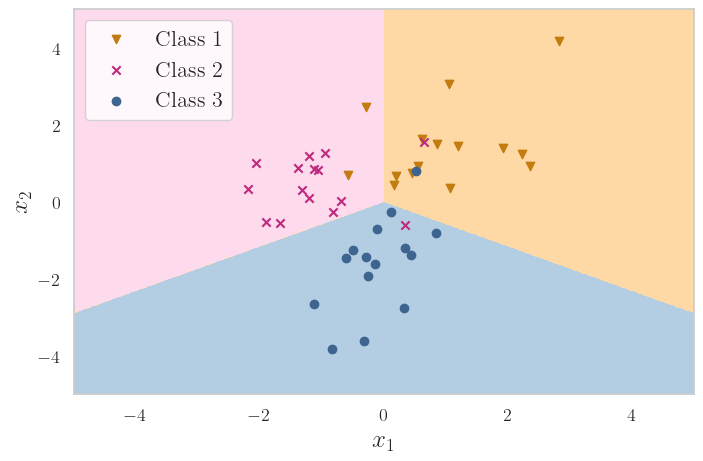

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

# set the grid
grid_points = 500
X1, X2 = np.meshgrid(
    np.linspace(-5, 5, grid_points),
    np.linspace(-5, 5, grid_points),
)

y_grid = get_ground_truth(torch.Tensor(np.vstack([X1.ravel(), X2.ravel()]).T)).numpy()

# plot the grid
im = ax.contourf(X1, X2, y_grid.reshape(grid_points, grid_points), levels=2, cmap="Pastel1")
# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=fontsize-5)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "Darker Pastel1", 
    # ["#B8CCE1", "#F8DAAC", "#F7DBEB"],
    ["#3d6590", "#c27c10", "#bf2a7f"]
)

ax.scatter(x_train[second_class, 0], x_train[second_class, 1], c="#c27c10", marker="v", label="Class 1")
ax.scatter(x_train[third_class, 0], x_train[third_class, 1], c="#bf2a7f", marker="x", label="Class 2")
ax.scatter(x_train[first_class, 0], x_train[first_class, 1], c="#3d6590", marker="o", label="Class 3")
# ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, marker="x", label="Train points", cmap=cmap)
# ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker="D", label="Test points", cmap=cmap)

lgnd = ax.legend(loc="upper left", frameon=True, fontsize=fontsize-2)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]

ax.set_xlabel("$x_1$", fontdict={"fontsize": fontsize})
x1ticks = ax.get_xticklabels()
ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
ax.set_ylabel("$x_2$", fontdict={"fontsize": fontsize})
x2ticks = ax.get_yticklabels()
ax.set_yticklabels(x2ticks, fontsize=fontsize-5)

plt.savefig(f"visual_example_dataset.pdf", bbox_inches="tight")
plt.show()

# Model

In [8]:
class Model(nn.Module):
    def __init__(self, hidden=300, seed=42) -> None:
        super().__init__()

        torch.manual_seed(seed)

        self.layers = nn.Sequential(
            nn.Linear(2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 3),
        )


    def forward(self, x):
        return self.layers(x)

    def upper_bound(self, ord=2):
        res = 1.0
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                res *= torch.linalg.matrix_norm(layer.weight, ord=ord)
        return res

# Optimise

We train for many epochs to make sure it trained enough to have a sharp decision boundary.

On an Apple M1 Pro CPU this training takes around 1m15s.

In [9]:
model = Model(hidden=100)
loss_f = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.02)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=0.98)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=1.0)
# epochs = 10_000
epochs = 100_000

print(f"Number of params = {get_vector_of_params(model).shape[0]:,}")

train_losses = []
test_losses = []
grad_norms = []


# test at initialisation
with torch.no_grad():
    y_pred = model(x_train)
    loss = loss_f(y_pred, y_train)
    y_pred = model(x_test)
    test_loss = loss_f(y_pred, y_test)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    print(f"Epoch: {0}/{epochs}, Train loss: {loss.item():.4f}, Test loss: {test_loss.item():.4f}")


for epoch in range(epochs):
    # train model
    optim.zero_grad()
    y_pred = model(x_train)
    loss = loss_f(y_pred, y_train)
    loss.backward()
    optim.step()
    lr_scheduler.step()

    grad_norm = torch.linalg.norm(get_grad_vector_of_params(model)).item()
    grad_norms.append(grad_norm)

    with torch.no_grad():
        y_pred = model(x_test)
        test_loss = loss_f(y_pred, y_test)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    print(f"Epoch: {epoch+1}/{epochs}, Train loss: {loss.item():.4f}, Test loss: {test_loss.item():.4f}\r", end="")

print()

Number of params = 10,703
Epoch: 0/100000, Train loss: 1.1601, Test loss: 1.1581
Epoch: 100000/100000, Train loss: 0.0011, Test loss: 4.5887


In [10]:
with torch.no_grad():
    y_pred_train = model(x_train)
    y_pred_train = torch.argmax(y_pred_train, dim=1).numpy()

    y_pred_test = model(x_test)
    y_pred_test = torch.argmax(y_pred_test, dim=1).numpy()

train_acc = np.mean(y_pred_train == y_train.numpy())* 100
test_acc = np.mean(y_pred_test == y_test.numpy()) * 100

print(f"Model accuaracy on train set: {train_acc:.2f}%, test set: {test_acc:.2f}%")

Model accuaracy on train set: 100.00%, test set: 73.33%


/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/3947207888.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/3947207888.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontsize=fontsize-5)


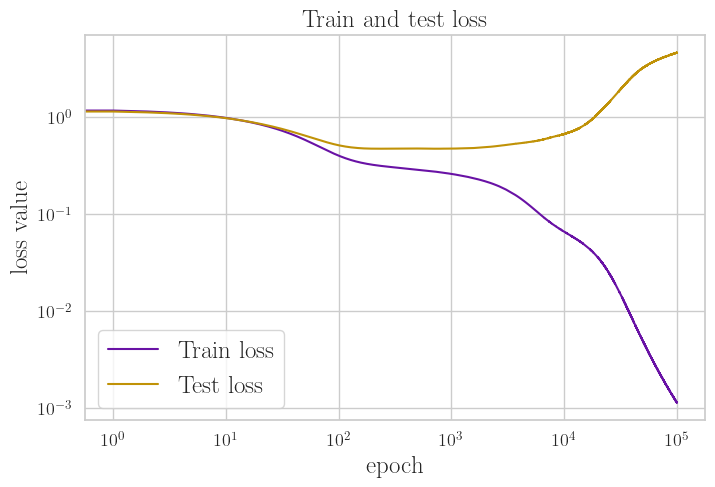

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Train and test loss", fontsize=fontsize)
ax.plot(train_losses, color=sbn_colours["deeppurple"], label="Train loss")
ax.plot(test_losses, color=sbn_colours["darkyellow"], label="Test loss")

ax.legend(fontsize=fontsize)

ax.set_xlabel("epoch", fontdict={"fontsize": fontsize})
xticks = ax.get_xticklabels()
ax.set_xticklabels(xticks, fontsize=fontsize-5)
ax.set_ylabel("loss value", fontdict={"fontsize": fontsize})
yticks = ax.get_yticklabels()
ax.set_yticklabels(yticks, fontsize=fontsize-5)

ax.loglog()

plt.savefig(f"visual_example_train_test_loss.pdf", bbox_inches="tight")
plt.show()

In [13]:
print(grad_norms[-1])

0.008574889972805977


This gradient norm is pretty small, which is good. That means that the model is at the end of its training and has successfully converged.

/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/1792451585.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/1792451585.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontsize=fontsize-5)


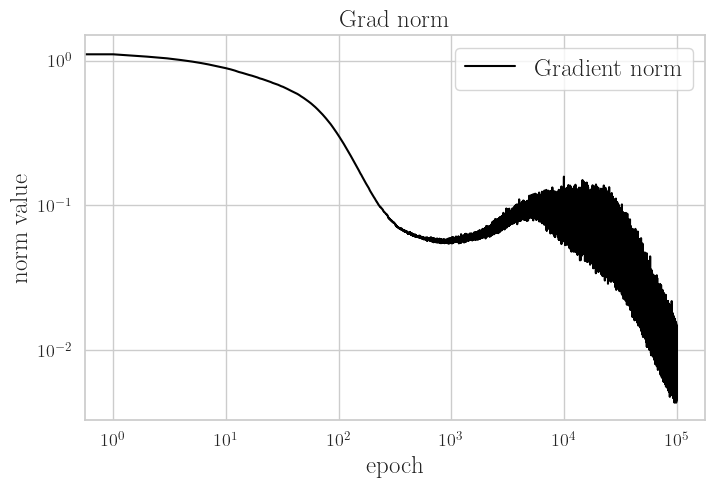

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title("Grad norm", fontsize=fontsize)
ax.plot(grad_norms, color="black", label="Gradient norm")

ax.legend(fontsize=fontsize)

ax.set_xlabel("epoch", fontdict={"fontsize": fontsize})
xticks = ax.get_xticklabels()
ax.set_xticklabels(xticks, fontsize=fontsize-5)
ax.set_ylabel("norm value", fontdict={"fontsize": fontsize})
yticks = ax.get_yticklabels()
ax.set_yticklabels(yticks, fontsize=fontsize-5)

ax.loglog()

plt.savefig(f"visual_example_grad_norm.pdf", bbox_inches="tight")
plt.show()

# Predictions

Let us now plot the model's decision boundary.

In [15]:
# set the grid
grid_points = 500
X1, X2 = np.meshgrid(
    np.linspace(-5, 5, grid_points),
    np.linspace(-5, 5, grid_points),
)

y_grid = get_ground_truth(torch.Tensor(np.vstack([X1.ravel(), X2.ravel()]).T)).numpy()
y_grid_pred = model(torch.Tensor(np.vstack([X1.ravel(), X2.ravel()]).T)).detach().numpy()
y_grid_pred = np.argmax(y_grid_pred, axis=1)

In [16]:
def get_decision_boundary(point_list, label_matrix):

    decision_boundary = []

    for i in range(grid_points):
        for j in range(grid_points):
            # check the right
            if j < grid_points - 1:
                if label_matrix[i, j] != label_matrix[i, j+1]:
                    p = (point_list[i*grid_points + j] + point_list[i*grid_points + j+1]) / 2
                    decision_boundary.append(p)
            # check the bottom
            if i < grid_points - 1:
                if label_matrix[i, j] != label_matrix[i+1, j]:
                    p = (point_list[i*grid_points + j] + point_list[(i+1)*grid_points + j]) / 2
                    decision_boundary.append(p)

    return np.array(decision_boundary)

In [17]:
point_list = np.vstack([X1.ravel(), X2.ravel()]).T
label_matrix = y_grid_pred.reshape(grid_points, grid_points)
decision_boundary = get_decision_boundary(point_list, label_matrix)

/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/2970951005.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [30]
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/2970951005.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/2970951005.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(x2ticks, fontsize=fontsize-5)


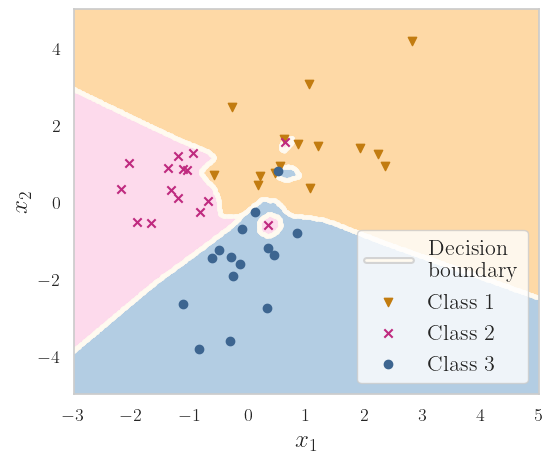

In [18]:
fig, ax = plt.subplots(figsize=(6, 5))

# plot the grid
im = ax.contourf(X1, X2, y_grid_pred.reshape(grid_points, grid_points), levels=2, cmap="Pastel1")

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "Darker Pastel1", 
    ["#3d6590", "#c27c10", "#bf2a7f"]
)

ax.plot([-100,-101], [-100,-100], c="floralwhite", linewidth=2, path_effects=[pe.Stroke(linewidth=5, foreground="lightgrey"), pe.Normal()], label="Decision\nboundary")
ax.scatter(decision_boundary[:, 0], decision_boundary[:, 1], c="floralwhite", marker=".", s=20)

ax.scatter(x_train[second_class, 0], x_train[second_class, 1], c="#c27c10", marker="v", label="Class 1")
ax.scatter(x_train[third_class, 0], x_train[third_class, 1], c="#bf2a7f", marker="x", label="Class 2")
ax.scatter(x_train[first_class, 0], x_train[first_class, 1], c="#3d6590", marker="o", label="Class 3")

ax.set_xlim(-3, 5)
ax.set_ylim(-5, 5)

lgnd = ax.legend(loc="lower right", frameon=True, fontsize=fontsize-2)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]

ax.set_xlabel("$x_1$", fontdict={"fontsize": fontsize})
x1ticks = ax.get_xticklabels()
ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
ax.set_ylabel("$x_2$", fontdict={"fontsize": fontsize})
x2ticks = ax.get_yticklabels()
ax.set_yticklabels(x2ticks, fontsize=fontsize-5)

plt.savefig(f"visual_example_pred.pdf", bbox_inches="tight")
plt.show()

This is a plot that shows the regions where model's predictions are wrong (where we see the results of overfitting to the noisy train data)

/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/4021163371.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/4021163371.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(x2ticks, fontsize=fontsize-5)


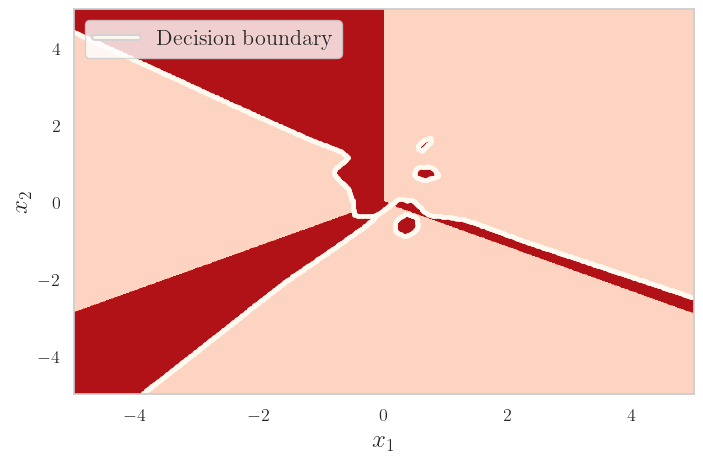

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))

y_grid_mistakes = (y_grid != y_grid_pred).astype(int)

# plot the grid
im = ax.contourf(X1, X2, y_grid_mistakes.reshape(grid_points, grid_points), levels=2, cmap="Reds")

ax.plot([-100,-101], [-100,-100], c="floralwhite", linewidth=2, path_effects=[pe.Stroke(linewidth=5, foreground="lightgrey"), pe.Normal()], label="Decision boundary")
ax.scatter(decision_boundary[:, 0], decision_boundary[:, 1], c="floralwhite", marker=".", s=20)
ax.legend(loc="upper left", frameon=True, fontsize=fontsize-2)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.set_xlabel("$x_1$", fontdict={"fontsize": fontsize})
x1ticks = ax.get_xticklabels()
ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
ax.set_ylabel("$x_2$", fontdict={"fontsize": fontsize})
x2ticks = ax.get_yticklabels()
ax.set_yticklabels(x2ticks, fontsize=fontsize-5)

# plt.savefig(f"visual_example_dataset.pdf", bbox_inches="tight")
plt.show()

# Lipschitz bounds

In [20]:
def get_lower_bound(model, x_range=[-1, 1], x_gridsize=10_000, batch_size=100, ord=2):
    model.eval()

    lower = 0.0

    xx = torch.linspace(x_range[0], x_range[1], x_gridsize)
    
    for x1_batch in tqdm(torch.split(xx, batch_size)):
        # construct a 2d list, where the first dimension is x_1st_dim_batch and the second is xx
        curr_x1 = torch.hstack([x1_batch] * x_gridsize).sort(descending=False).values
        curr_x2 = torch.hstack([xx] * len(x1_batch))
        x_batch = torch.stack([curr_x1, curr_x2], dim=1)
        
        lower_curr = compute_jac_norm(model, x_batch, ord=ord).max()
        if lower < lower_curr:
            lower = lower_curr
    return lower

On the Apple M1 Pro CPU, this computation takes around 2mins 15s.

You can decrease the `x_gridsize` to obtain results faster at the cost of precision.

In [21]:
lower_bound_precise = get_lower_bound(model, [-5, 5], x_gridsize=1000, batch_size=100)
lower_bound_precise

100%|██████████| 10/10 [02:15<00:00, 13.54s/it]


tensor(144.1936)

In [22]:
lower_bounds_train = compute_jac_norm(model, x_train).detach().numpy()
upper = model.upper_bound().item()

print(f"Model: Lower bound on x_train = {np.max(lower_bounds_train):.3f}, Lower bound on X = {lower_bound_precise:.3f}, Upper bound = {upper:.3f}")

Model: Lower bound on x_train = 135.815, Lower bound on X = 144.194, Upper bound = 389.097


Now let us plot the lower Lipschitz space.

In [23]:
# grid_points = 200
grid_points = 500


x1 = np.linspace(-5, 5, grid_points, dtype=np.float32)
x2 = np.linspace(-5, 5, grid_points, dtype=np.float32)
X1, X2 = np.meshgrid(x1, x2)
xx_grid = np.vstack([X1.ravel(), X2.ravel()]).T

xx_grid = torch.Tensor(xx_grid)

lower_bound_grid = compute_jac_norm(model, xx_grid).detach().numpy()

In [24]:
np.max(lower_bound_grid)

144.19362

/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/1896451216.py:4: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in im.collections:
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/1896451216.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/1896451216.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(x2ticks, fontsize=fontsize-5)


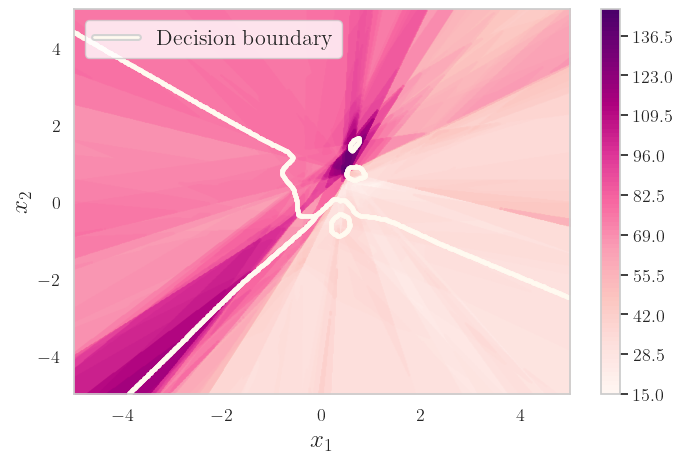

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
# ax.set_title("Lower bound", fontsize=fontsize)
im = ax.contourf(X1, X2, lower_bound_grid.reshape(grid_points, grid_points), levels=100, cmap="RdPu")
for c in im.collections:
    c.set_edgecolor("face")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=fontsize-5)

ax.plot([-100,-101], [-100,-100], c="floralwhite", linewidth=2, path_effects=[pe.Stroke(linewidth=5, foreground="lightgrey"), pe.Normal()], label="Decision boundary")
ax.scatter(decision_boundary[:, 0], decision_boundary[:, 1], c="floralwhite", marker=".", s=20)

# ax.scatter(x_train[second_class, 0], x_train[second_class, 1], c="#c27c10", marker="v", label="Class 1")
# ax.scatter(x_train[third_class, 0], x_train[third_class, 1], c="#bf2a7f", marker="x", label="Class 2")
# ax.scatter(x_train[first_class, 0], x_train[first_class, 1], c="#3d6590", marker="o", label="Class 3")

# ax.scatter([-100], [-100], c="black", marker="x", label="Train points")
# ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, marker="x", cmap=cmap)
# ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker="D", label="True test", cmap=cmap)

lgnd = ax.legend(loc="upper left", frameon=True, fontsize=fontsize-2)


ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.set_xlabel("$x_1$", fontdict={"fontsize": fontsize})
x1ticks = ax.get_xticklabels()
ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
ax.set_ylabel("$x_2$", fontdict={"fontsize": fontsize})
x2ticks = ax.get_yticklabels()
ax.set_yticklabels(x2ticks, fontsize=fontsize-5)

plt.savefig(f"visual_example_lower_lip.pdf", bbox_inches="tight")
plt.show()

/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/2266590545.py:4: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in im.collections:
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/2266590545.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/2266590545.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(x2ticks, fontsize=fontsize-5)


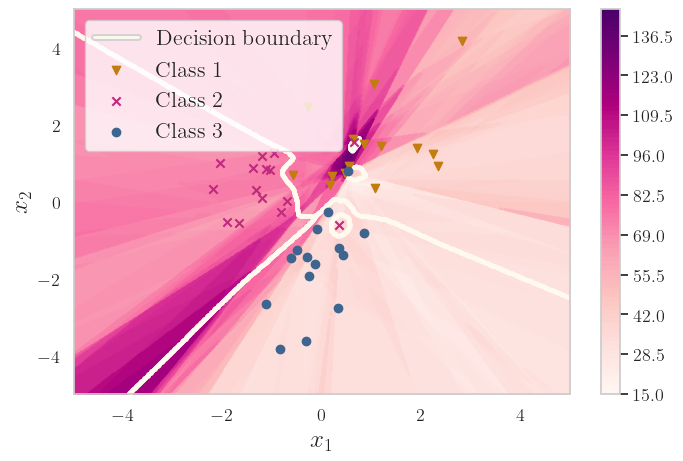

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
# ax.set_title("Lower bound", fontsize=fontsize)
im = ax.contourf(X1, X2, lower_bound_grid.reshape(grid_points, grid_points), levels=100, cmap="RdPu")
for c in im.collections:
    c.set_edgecolor("face")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=fontsize-5)

ax.plot([-100,-101], [-100,-100], c="floralwhite", linewidth=2, path_effects=[pe.Stroke(linewidth=5, foreground="lightgrey"), pe.Normal()], label="Decision boundary")
ax.scatter(decision_boundary[:, 0], decision_boundary[:, 1], c="floralwhite", marker=".", s=20)

ax.scatter(x_train[second_class, 0], x_train[second_class, 1], c="#c27c10", marker="v", label="Class 1")
ax.scatter(x_train[third_class, 0], x_train[third_class, 1], c="#bf2a7f", marker="x", label="Class 2")
ax.scatter(x_train[first_class, 0], x_train[first_class, 1], c="#3d6590", marker="o", label="Class 3")

# ax.scatter([-100], [-100], c="black", marker="x", label="Train points")
# ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, marker="x", cmap=cmap)
# ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker="D", label="True test", cmap=cmap)

lgnd = ax.legend(loc="upper left", frameon=True, fontsize=fontsize-2)


ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.set_xlabel("$x_1$", fontdict={"fontsize": fontsize})
x1ticks = ax.get_xticklabels()
ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
ax.set_ylabel("$x_2$", fontdict={"fontsize": fontsize})
x2ticks = ax.get_yticklabels()
ax.set_yticklabels(x2ticks, fontsize=fontsize-5)

plt.savefig(f"visual_example_lower_lip_with_train.pdf", bbox_inches="tight")
plt.show()

/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/3315350762.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/3315350762.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(x2ticks, fontsize=fontsize-5)


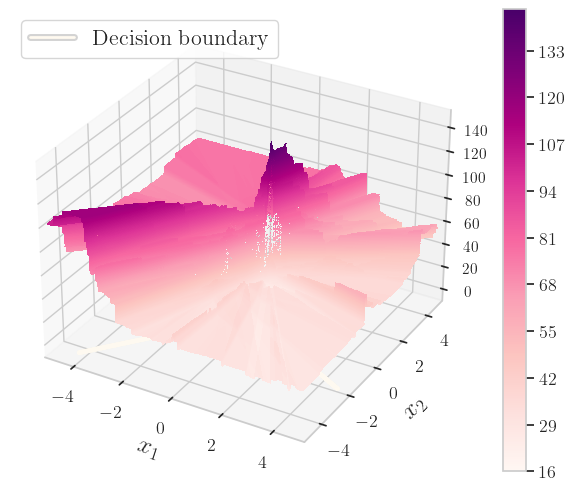

In [27]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={"projection": "3d"})

# ax.set_title("Lower bound", fontsize=fontsize)
im = ax.contourf(X1, X2, lower_bound_grid.reshape(grid_points, grid_points), levels=300, cmap="RdPu")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=fontsize-5)

ax.plot([-100,-101], [-100,-100], c="floralwhite", linewidth=2, path_effects=[pe.Stroke(linewidth=5, foreground="lightgrey"), pe.Normal()], label="Decision boundary")
ax.scatter(decision_boundary[:, 0], decision_boundary[:, 1], c="floralwhite", marker=".", s=20)

# ax.scatter(x_train[second_class, 0], x_train[second_class, 1], c="#c27c10", marker="v", label="Class 1")
# ax.scatter(x_train[third_class, 0], x_train[third_class, 1], c="#bf2a7f", marker="x", label="Class 2")
# ax.scatter(x_train[first_class, 0],x_train[first_class, 1], c="#3d6590", marker="o", label="Class 3")

# ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, marker="x", label="Train points", cmap=cmap)
# ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker="D", label="True test", cmap=cmap)

lgnd = ax.legend(loc="upper left", frameon=True, fontsize=fontsize-2)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.set_xlabel("$x_1$", fontdict={"fontsize": fontsize})
x1ticks = ax.get_xticklabels()
ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
ax.set_ylabel("$x_2$", fontdict={"fontsize": fontsize})
x2ticks = ax.get_yticklabels()
ax.set_yticklabels(x2ticks, fontsize=fontsize-5)

# plt.savefig(f"visual_example_lower_lip.pdf", bbox_inches="tight")
plt.show()

Here is some Out-of-Distribution (OOD) computation.

In [28]:
# grid_points = 200
grid_points = 500


x1_ood = np.linspace(-10, 10, grid_points, dtype=np.float32)
x2_ood = np.linspace(-10, 10, grid_points, dtype=np.float32)
X1_ood, X2_ood = np.meshgrid(x1_ood, x2_ood)
xx_ood_grid = np.vstack([X1_ood.ravel(), X2_ood.ravel()]).T

xx_ood_grid = torch.Tensor(xx_ood_grid)

lower_bound_ood_grid = compute_jac_norm(model, xx_ood_grid).detach().numpy()

In [29]:
point_list_ood = np.vstack([X1_ood.ravel(), X2_ood.ravel()]).T

y_grid_pred_ood = model(torch.Tensor(point_list_ood)).detach().numpy()
y_grid_pred_ood = np.argmax(y_grid_pred_ood, axis=1)

label_matrix_ood = y_grid_pred_ood.reshape(grid_points, grid_points)
decision_boundary_ood = get_decision_boundary(point_list_ood, label_matrix_ood)

/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/739323268.py:5: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in im.collections:
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/739323268.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
/var/folders/ly/3qjmjt3n7jn1xhsqztr5tb640000gn/T/ipykernel_9828/739323268.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(x2ticks, fontsize=fontsize-5)


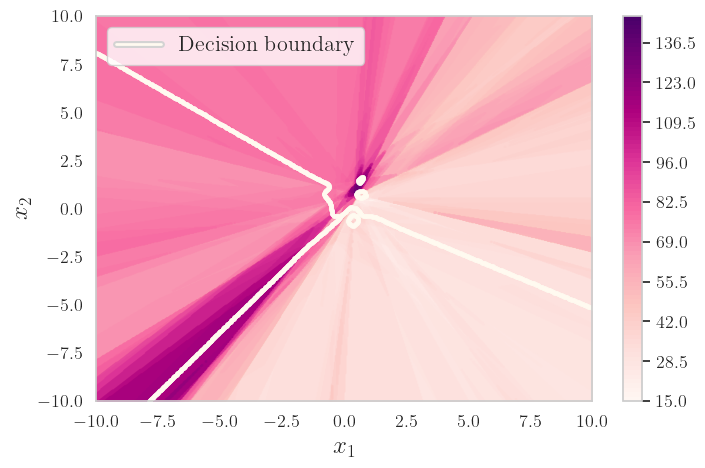

In [30]:
# OOD
fig, ax = plt.subplots(figsize=(8, 5))
# ax.set_title("Lower bound", fontsize=fontsize)
im = ax.contourf(X1_ood, X2_ood, lower_bound_ood_grid.reshape(grid_points, grid_points), levels=100, cmap="RdPu")
for c in im.collections:
    c.set_edgecolor("face")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=fontsize-5)

ax.plot([-100,-101], [-100,-100], c="floralwhite", linewidth=2, path_effects=[pe.Stroke(linewidth=5, foreground="lightgrey"), pe.Normal()], label="Decision boundary")
ax.scatter(decision_boundary_ood[:, 0], decision_boundary_ood[:, 1], c="floralwhite", marker=".", s=20)
lgnd = ax.legend(loc="upper left", frameon=True, fontsize=fontsize-2)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.set_xlabel("$x_1$", fontdict={"fontsize": fontsize})
x1ticks = ax.get_xticklabels()
ax.set_xticklabels(x1ticks, fontsize=fontsize-5)
ax.set_ylabel("$x_2$", fontdict={"fontsize": fontsize})
x2ticks = ax.get_yticklabels()
ax.set_yticklabels(x2ticks, fontsize=fontsize-5)

plt.savefig(f"visual_example_lower_lip_ood.pdf", bbox_inches="tight")
plt.show()

In [31]:
print(f"Lower bound on x_train = {np.max(lower_bounds_train):.3f}, Lower bound on X = {np.max(lower_bound_precise.item()):.3f},")
print(f"Lower bound on X OOD = {np.max(lower_bound_ood_grid):.3f}, Upper bound = {upper:.3f}")

Lower bound on x_train = 135.815, Lower bound on X = 144.194,
Lower bound on X OOD = 144.194, Upper bound = 389.097
